In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Reinforcement Learning

## Session 05b: Control



##  Frozen Lake with SARSA

    
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

### State Action Reward State Action (SARSA) 

As indicated by the name SARSA, it updates the $Q(s_{t}, a_{t})$, according to the current state $s_{t}$, the action choose $a_{t}$, the reward $r_{t}$ due to this action, the new state $s_{t+1}$ after taking this action, and the action $a_{t+1}$ picked for this new state.
Given that, the Q-value table can be updated by:

$$Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha[r_{t} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})]$$

where, $\alpha$ stands for the learning rate and $\gamma$ represents the discount factor. It can be seen in the definition that the SARSA method aims to update the policy through interactions with the environment, so it belongs to the on-policy learning algorithm family.

In [2]:
# import statements
import os
import random

import gym

import numpy as np

import pandas as pd

from matplotlib import pyplot

import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from collections import defaultdict

import seaborn as sns

from time import sleep

from IPython.display import clear_output, display

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)


# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

STEPS = 10000

ALPHA = 0.01 #0.85
GAMMA = 0.90
EPSILON = 0.8

 ## Load Frozen Lake Environment

(-0.5, 511.5, 511.5, -0.5)

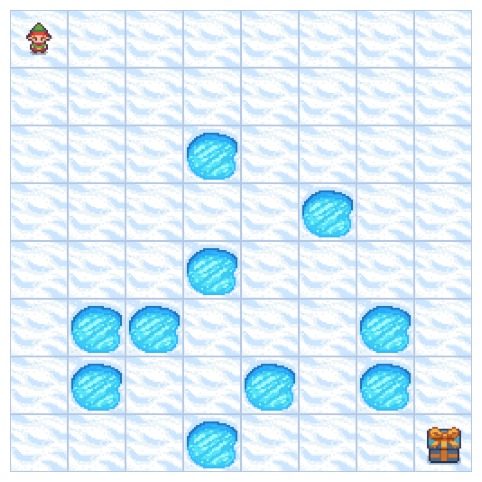

In [4]:
# Make the environment based on non-deterministic policy
#env = gym.make('FrozenLake8x8-v1', render_mode='rgb_array')

env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode='rgb_array')

GRID_SIZE = (8,8)

env.reset(seed = RANDOM_STATE)

img = plt.imshow(env.render())

plt.grid('off')

plt.axis(False)

## Environment - FrozenLake

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 8 x 8 grid world. 
States $S$ are from 0 to 63

SFFFFFFF       (S: starting point, safe)<br>
FFFFFFFF       (F: frozen surface, safe)<br>
FFFHFFFF       (H: hole, fall to your doom)<br>
FFFFFHFF       (G: goal, where the frisbee is located)<br>
FFFHFFFF<br>
FHHFFFHF<br>
FHFFHFHF<br>
FFFHFFFG <br>

<img src='./images/Frozenlake8x8.png' style='width:400px;'>

In [5]:
# Helper function to plot the grid

def fn_plot_heatmap(values, opt_policy):
    
    fig, ax = plt.subplots()
    
    act = [action_mappings[action] for action in np.argmax(opt_policy, axis=1)]
    
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(8,8)

    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
    
    plt.show()

In [6]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


1 0.0 False False {'prob': 0.3333333333333333}


/home/pks/RL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


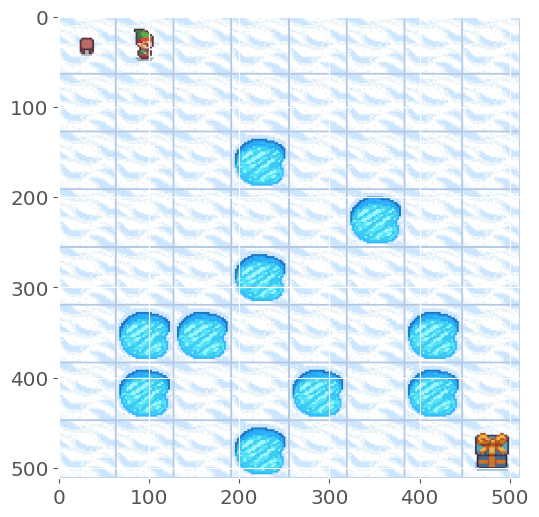

In [7]:
# Go right once (action = 2), we should go to the right but we did not!
env.reset()

action = 2

observation, reward, terminated, truncated, prob = env.step(action)

img = plt.imshow(env.render())

print (observation, reward, terminated, truncated, prob)

In [8]:
Q = {}

for s in range(env.observation_space.n):
    
    for a in range(env.action_space.n):
        
        Q[(s,a)] = 0.0

In [9]:
def epsilon_greedy(state, epsilon):
    
    if random.uniform(0,1) < epsilon:
        
        return env.action_space.sample() # random action
    
    else:
        
        # Preferred Action
        return max(list(range(env.action_space.n)), key = lambda x: Q[(state,x)]) 

In [10]:
for i in trange(STEPS):
    
    # Initialize the state, Reset the environment
    state = env.reset()[0]
    
    # select the action using epsilon-greedy policy
    action = epsilon_greedy ( state, EPSILON )
    
    while True:
        
        # then we perform the action and move to the next state, and receive the reward
        nextstate, reward, terminated, truncated, prob = env.step(action)
        
        # again, we select the next action using epsilon greedy policy
        nextaction = epsilon_greedy(nextstate, EPSILON) 
    
        # we calculate the Q value of previous state using our update rule
        Q[(state,action)] += ALPHA * (reward + GAMMA * Q[(nextstate,nextaction)]-Q[(state,action)])

        # finally we update our state and action with next action and next state
        action = nextaction
        
        state = nextstate
        
        
        # we will break the loop, if we are at the terminal state of the episode
        done  = terminated or truncated
        
        if done:
            break
            

env.close()

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1913.28it/s]


In [11]:
V = {}
for s, a in Q:
    
    if a == 0:
        
        v_val = Q[(s,a)]
    
    else:
        
        v_val = max(v_val,Q[(s,a)])
        
    V[s] = v_val

In [12]:
def fn_get_policy(grid, V):
    
    # Find a policy corresponding to the value function
    policy = np.zeros((grid.observation_space.n, grid.action_space.n))

    for state in range(grid.observation_space.n):
        
        # Create a vector of same as the number of actions
        action_values = np.zeros(env.action_space.n)

        for action in range(env.action_space.n): # iterate through the actions

            for probability, next_state, reward, terminated in grid.P[state][action]:
                action_values[action] += probability * (reward + GAMMA * V[next_state])
                
        # Choose the best action
        best_action = np.argmax(action_values)
        
        #print ('State :', state, action_values, best_action)
        
        # one hot encode the policy
        policy[state][best_action] = 1.0

    return policy

In [13]:
# Based on the values calculated get the policy for validation
policy = fn_get_policy(env, V)
#policy

In [14]:
# create a grid for plotting
plot_grid = np.zeros(GRID_SIZE)

for k, v in V.items():
    i = k // GRID_SIZE[0]
    j = k % GRID_SIZE[1]
    plot_grid[i,j] = v
#plot_grid

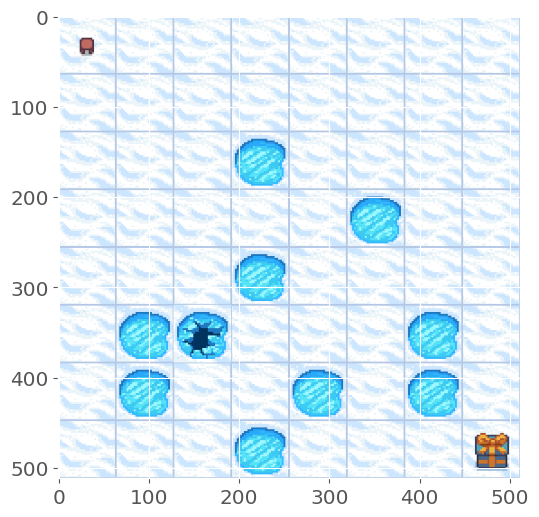

In [15]:
def fn_set_holes(plt_grid):
    plt_grid[plt_grid == 0 ]= -plt_grid.max()/2
    
img = plt.imshow(env.render())

In [16]:
fn_set_holes(plot_grid) 

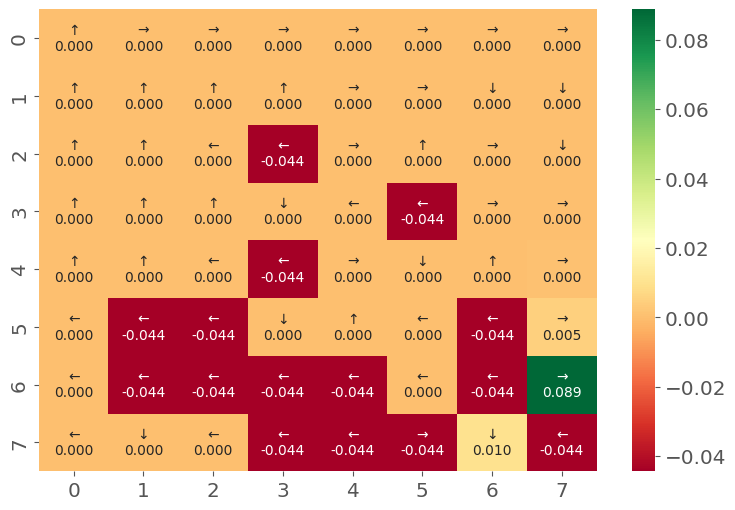

In [17]:
fn_plot_heatmap(plot_grid, policy)

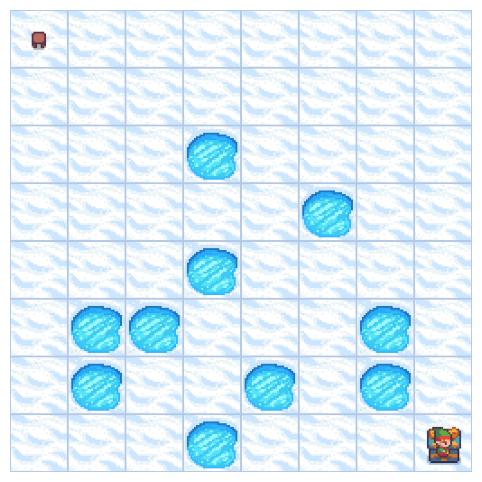

In [22]:
lives = 5

highscore = 0

points = 0 # keep track of the reward each episode

for i_episode in range(lives): # run 20 episodes
    
    observation = env.reset()[0]
    
    img = plt.imshow(env.render())
    
    while True: # run until episode is done
        
        action = np.argmax(policy[observation])
        
        observation, reward, terminated, truncated, info = env.step(action)
        
        points += reward
            
        done = terminated or truncated
        
        img.set_data(env.render())
            
        plt.axis('off')

        display(plt.gcf())

        clear_output(wait=True)

        sleep(0.05)
        if done:
            #env.render()
            #print ('Iteration', n_iter, observation, reward, done, info)

            if points > highscore: # record high score
                highscore = points
            break

In [19]:
n_iteration = 1000

highscore = 0

data_row = []

for n_iter in trange(n_iteration):

    points = 0 # keep track of the reward each episode
    
    data_dict = {}
    
    for i_episode in range(20): # run 20 episodes
        
        observation = env.reset()[0]
        
        while True: # run until episode is done
            
            action = np.argmax(policy[observation])
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            points += reward
            
            done = terminated or truncated
            
            if done:
                
                #env.render()
                #print ('Iteration', n_iter, observation, reward, done, info)

                if points > highscore: # record high score
                    
                    highscore = points
                
                break
    
    data_dict['run'] = n_iter
    
    data_dict['Points']=  points
    
    data_row.append(data_dict)

100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 75.11it/s]


In [20]:
# Dataframe for ease of plotting
results_df =  pd.DataFrame(data_row)

results_df.head()

,run,Points
0,0,13.0
1,1,8.0
2,2,11.0
3,3,13.0
4,4,17.0


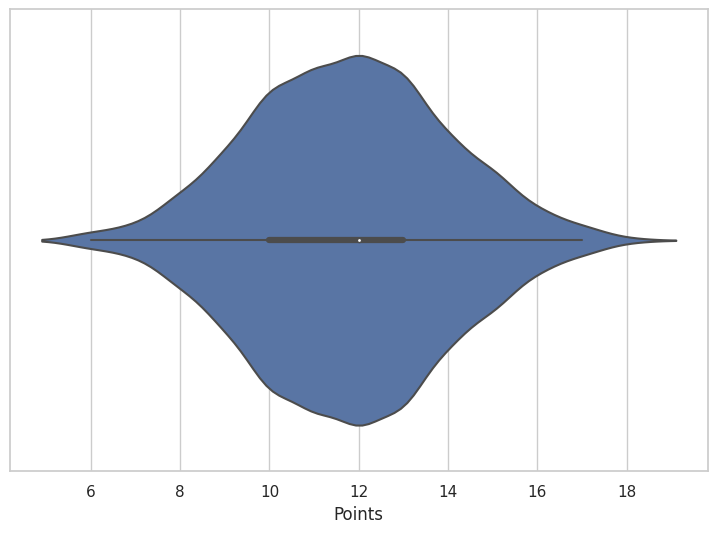

In [21]:
sns.set_theme(style="whitegrid")

ax = sns.violinplot(x=results_df["Points"])